<a href="https://colab.research.google.com/github/Kogo0813/Windroad8/blob/main/u-net%ED%98%95%ED%83%9C%20gen%2Bonetomanyconvlstm2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!echo $COLAB_TPU_ADDR #코랩에서 런타임->런타임 유형 변경 -> TPU로 변경

10.124.202.26:8470


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from osgeo import gdal

# TPU gRPC 접근 URI
TPU_PATH = f"grpc://{os.environ['COLAB_TPU_ADDR']}"
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=TPU_PATH)
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

In [3]:
strategy = tf.distribute.experimental.TPUStrategy(resolver)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

%cd drive
%cd MyDrive
%cd data_from_s

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive
/content/drive/MyDrive
/content/drive/MyDrive/data_from_s


In [5]:
loaded_data = np.load('120*150npz.npz')
loaded_X = loaded_data['x']
loaded_Y = loaded_data['y']

In [6]:
param = []
h = np.array([1, 2, 3])
s = np.array([0, 1, 2, 3, 4, 5])
d = np.array([0, 60, 120, 180, 240, 300])

h_mean = np.mean(h)
h_std = np.std(h)

s_mean = np.mean(s)
s_std = np.std(s)

d_mean = np.mean(d)
d_std = np.std(d)

for i in range(1, 12): 
  for h in range(1, 4):
    for s in range(0,6): 
      for d in range(0, 360, 60): 
        if i==3 and h==1 and s ==3 : 
          continue
        if i==3 and h==3 and s ==1 and d==300: 
          continue
        if i==3 and h==3 and s ==5 and d==120: 
          continue
        if i==8 and h==1 and s ==3 and d==120: 
          continue
        if i==9 and h==2 and s ==3 and d==300: 
          continue 
        height = (h-h_mean)/h_std
        speed = (s-s_mean)/s_std
        direction =  (d-d_mean)/d_std
        param.append(np.array((height, speed, direction)))

In [7]:
param = np.array(param)

In [8]:
loaded_X = loaded_X.reshape(1178,120,150,2)

In [9]:
from sklearn.preprocessing import StandardScaler

scaled_X = []
scaled_Y = []
for i in range (0,1178):
  scaler_terrain = StandardScaler()
  scaler_landuse = StandardScaler()
  landuse = scaler_terrain.fit_transform(loaded_X[i,:,:,0])
  terrain = scaler_landuse.fit_transform(loaded_X[i,:,:,1])
  scaled_X.append(np.dstack((landuse,terrain)))
  scaled_uzvz = []
  for j in range(0,10):
    scaler_uz = StandardScaler()
    scaler_vz = StandardScaler()
    uz = scaler_uz.fit_transform(loaded_Y[i,j,:,:,0])
    vz = scaler_vz.fit_transform(loaded_Y[i,j,:,:,1])
    scaled_uzvz.append(np.dstack((uz,vz)))
  scaled_Y.append(scaled_uzvz)

In [10]:
scaled_X = np.array(scaled_X)
scaled_Y = np.array(scaled_Y)

In [11]:
X_final = scaled_X[:,:64,:64,:]
X_final.shape

(1178, 64, 64, 2)

In [12]:
param.shape

(1178, 3)

In [12]:
Y_final = scaled_Y[:,0,:64,:64,:]
Y_final.shape

(1178, 64, 64, 2)

In [4]:
#Terrain, Landuse 두개의 이미지를 u-net형태로 구성, 중간에 flatten한 뒤 정수 입력변수 3개를 fullyconneted한 후 다시 업샘플링 하는 방식
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Concatenate, Conv2DTranspose, LeakyReLU, Dense, Flatten,Reshape
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from keras.utils import get_custom_objects
with strategy.scope():
  def r2_metric(y_true, y_pred):
      SS_res =  K.sum(K.square(y_true - y_pred))
      SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
      return (1 - SS_res/(SS_tot + K.epsilon()))

  get_custom_objects().update({'r2_metric': r2_metric})

  def conv_block(x, filters, kernel_size=3, strides=2, use_bn=False, activation='relu'):
      x = Conv2D(filters, kernel_size, strides=strides, padding='same',kernel_initializer='he_normal')(x)
      if use_bn:
          x = BatchNormalization()(x)
      x = LeakyReLU(alpha=0.2)(x) 
      return x

  def deconv_block(x, filters, kernel_size=3, strides=2, use_bn=False, activation='relu'):
      x = Conv2DTranspose(filters, kernel_size, strides=strides, padding='same',kernel_initializer='he_normal')(x)
      if use_bn:
        x = BatchNormalization()(x)
      x = LeakyReLU(alpha=0.2)(x)
      return x

  def generator(input_shape=(64, 64, 2), int_input_shape=(3,), output_channels=2):
      inputs = Input(shape=input_shape)
      input_integers = Input(shape=int_input_shape)

      enc1 = conv_block(inputs, 64)
      enc2 = conv_block(enc1, 128)
      enc3 = conv_block(enc2, 256)
      enc4 = conv_block(enc3, 512)

      flatten_enc = Flatten()(enc4)
      combined = Concatenate()([flatten_enc, input_integers])
      fc1 = Dense(8192)(combined)
      reshaped_combined = Reshape((4, 4, 512))(fc1)

      dec1 = deconv_block(reshaped_combined, 512)
      dec1 = Concatenate()([dec1, enc3])
      dec2 = deconv_block(dec1, 256)
      dec2 = Concatenate()([dec2, enc2])
      dec3 = deconv_block(dec2, 128)
      dec3 = Concatenate()([dec3, enc1])
      dec4 = deconv_block(dec3, 64)

      outputs = Conv2D(output_channels, kernel_size=1, strides=1, padding='same', activation='tanh')(dec4)

      return Model(inputs=[inputs, input_integers], outputs=outputs)

  model = generator()
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), loss='mse', metrics='r2_metric')
  model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   1216        ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 32, 32, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 16, 16, 128)  73856       ['leaky_re_lu[0][0]']            
                                                                                              

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


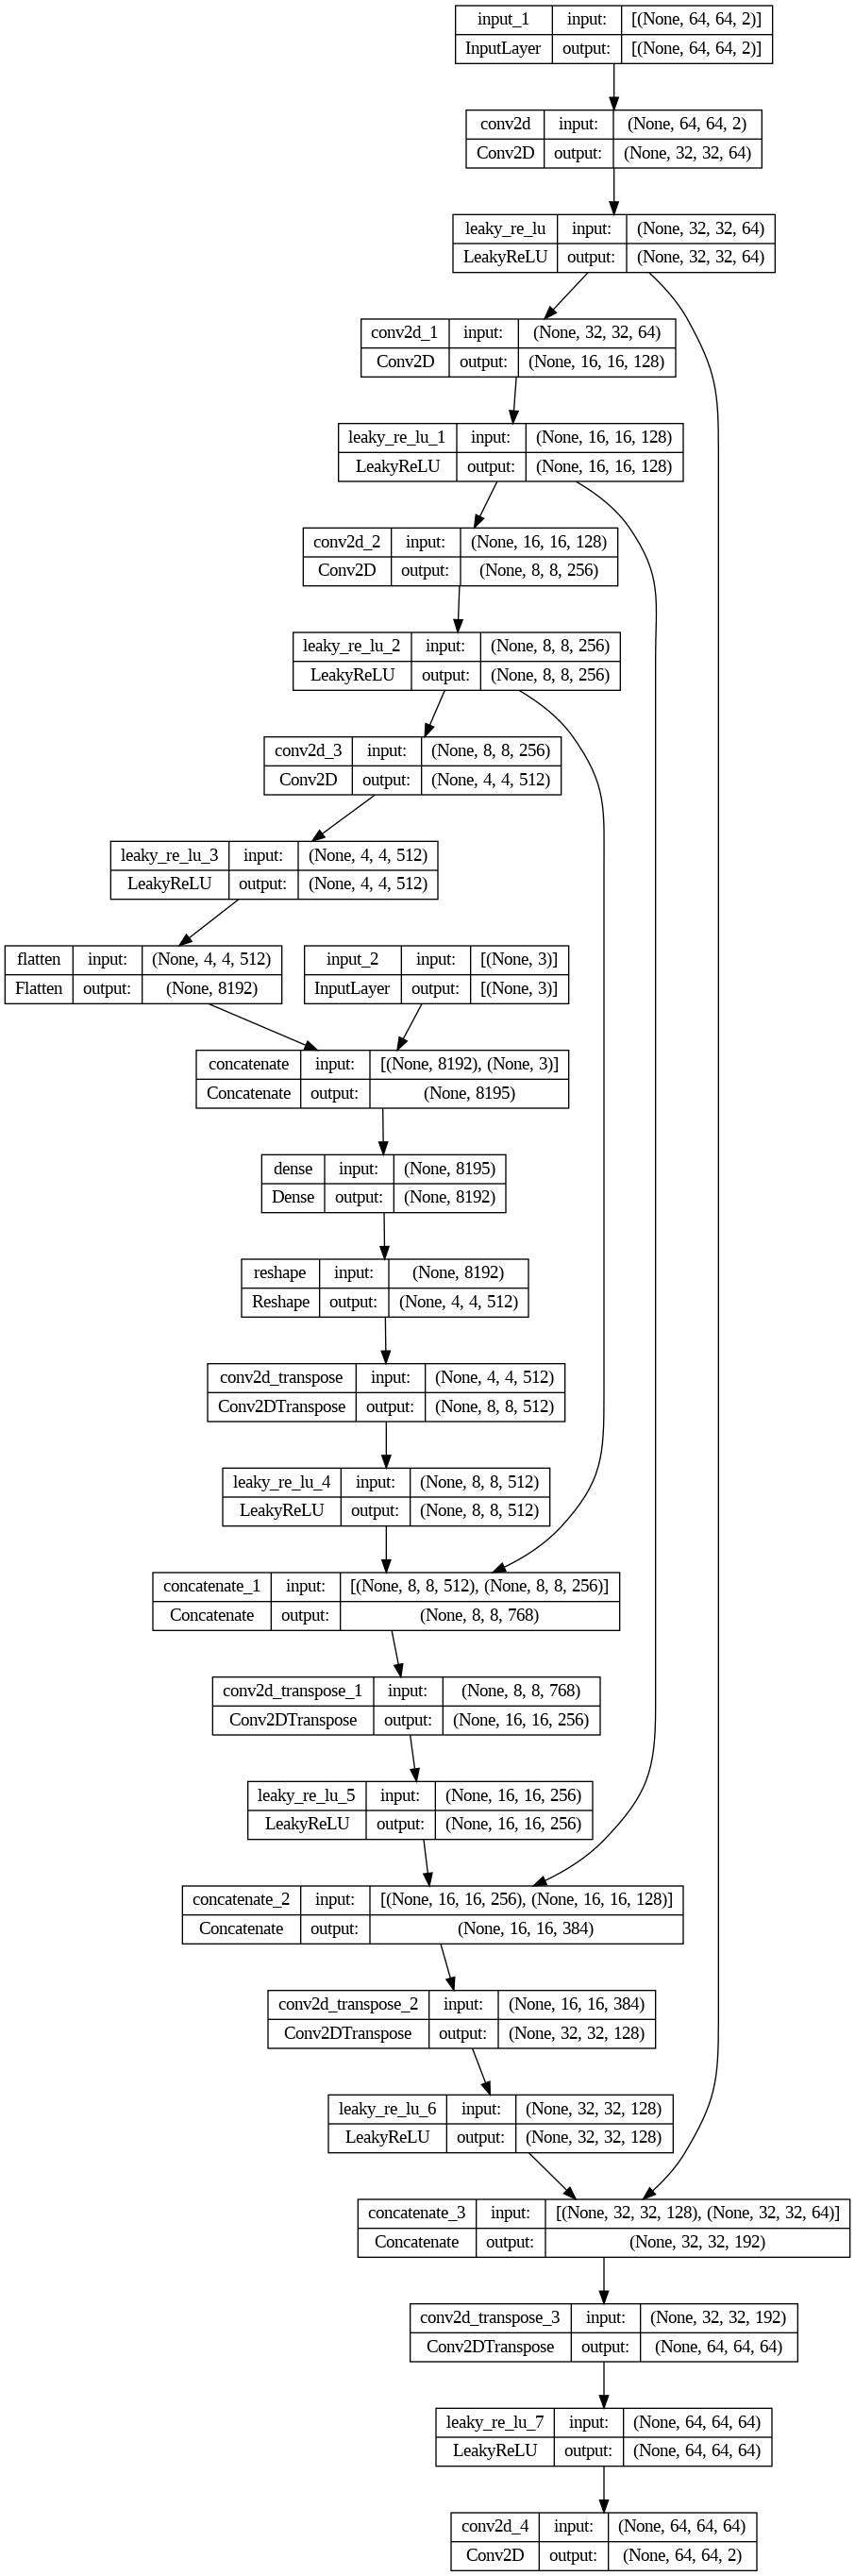

In [6]:
!pip install pydot
!pip install graphviz
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

X_final1 = X_final[:1177,:,:,:]
Y_final1 = Y_final[:1177,:,:,:]
param1 = param[:1177,:]
x_train, x_val,param_train, param_val, y_train, y_val = train_test_split(X_final1, param1, Y_final1, test_size=0.2, shuffle=True)
with strategy.scope():
  early_stop = EarlyStopping(monitor='val_r2_metric',min_delta=0.01, patience=5, verbose=1, mode='max',restore_best_weights=True)
  history = model.fit([x_train, param_train], y_train, epochs=100, batch_size=16, validation_data=([x_val, param_val], y_val), callbacks=[early_stop])

Epoch 1/100
59/59 [==============================] - 15s 159ms/step - loss: 0.2252 - r2_metric: 0.7503 - val_loss: 0.1288 - val_r2_metric: 0.8591
Epoch 2/100
59/59 [==============================] - 3s 56ms/step - loss: 0.1295 - r2_metric: 0.8561 - val_loss: 0.1232 - val_r2_metric: 0.8653
Epoch 3/100
59/59 [==============================] - 3s 56ms/step - loss: 0.1253 - r2_metric: 0.8608 - val_loss: 0.1207 - val_r2_metric: 0.8679
Epoch 4/100
59/59 [==============================] - 4s 71ms/step - loss: 0.1226 - r2_metric: 0.8639 - val_loss: 0.1186 - val_r2_metric: 0.8703
Epoch 5/100
59/59 [==============================] - 3s 54ms/step - loss: 0.1210 - r2_metric: 0.8655 - val_loss: 0.1188 - val_r2_metric: 0.8700
Epoch 6/100
59/59 [==============================] - 3s 56ms/step - loss: 0.1201 - r2_metric: 0.8665 - val_loss: 0.1188 - val_r2_metric: 0.8700
Epoch 7/100
59/59 [==============================] - 3s 56ms/step - loss: 0.1191 - r2_metric: 0.8677 - val_loss: 0.1179 - val_r2_metri

In [ ]:
sample = X_final[1177]
param_sample = param[1177]

with strategy.scope():
    predictions = model.predict([sample,param_sample])

1/1 [==============================] - 2s 2s/step


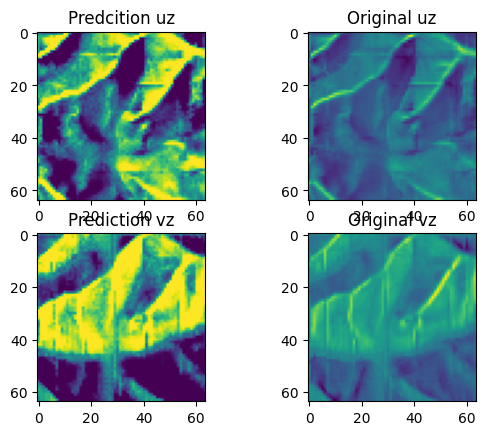

In [ ]:
predictions = predictions.reshape(64,64,2)
fig, ax = plt.subplots(2, 2)

ax[0][0].imshow(predictions[:,:,0])
ax[0][0].set_title('Predcition uz')
ax[0][1].imshow(Y_final[1177,:,:,0])
ax[0][1].set_title('Original uz')
ax[1][0].imshow(predictions[:,:,1])
ax[1][0].set_title('Prediction vz')
ax[1][1].imshow(Y_final[1177,:,:,1])
ax[1][1].set_title('Original vz')

plt.show()

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D
import tensorflow.keras.backend as K
from keras.utils import get_custom_objects
with strategy.scope():
  def r2_metric(y_true, y_pred):
      SS_res =  K.sum(K.square(y_true - y_pred))
      SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
      return (1 - SS_res/(SS_tot + K.epsilon()))

  get_custom_objects().update({'r2_metric': r2_metric})

  def create_image_sequence_prediction_model(input_shape=(1, 64, 64, 2), output_timesteps=9):
    inputs = Input(shape=input_shape)
    x = ConvLSTM2D(filters=64, kernel_size=(3, 3), activation='tanh', padding='same', return_sequences=True)(inputs)
    x = ConvLSTM2D(filters=64, kernel_size=(3, 3), activation='tanh', padding='same', return_sequences=True)(x)
    x = ConvLSTM2D(filters=64, kernel_size=(3, 3), activation='tanh', padding='same', return_sequences=True)(x)
    outputs = TimeDistributed(Conv2D(filters=2, kernel_size=(3, 3), activation='linear', padding='same'))(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

  input_shape = (1, 64, 64, 2)
  output_timesteps = 9
  model2 = create_image_sequence_prediction_model(input_shape, output_timesteps)

  model2.compile(optimizer='adam', loss='mse', metrics='r2_metric')
  model2.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1, 64, 64, 2)]    0         
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 1, 64, 64, 64)     152320    
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 1, 64, 64, 64)     295168    
                                                                 
 conv_lstm2d_2 (ConvLSTM2D)  (None, 1, 64, 64, 64)     295168    
                                                                 
 time_distributed (TimeDistr  (None, 1, 64, 64, 2)     1154      
 ibuted)                                                         
                                                                 
Total params: 743,810
Trainable params: 743,810
Non-trainable params: 0
_____________________________________________________

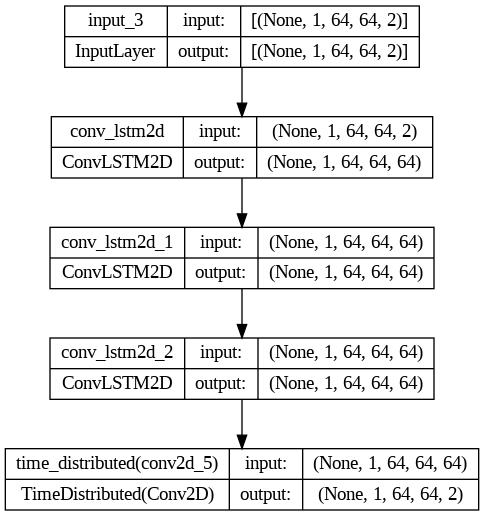

In [9]:
plot_model(model2, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
#코랩 세션 다운... 샘플 수가 많아서 그런것으로 생각 됨
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

conv_x_final = scaled_Y[:, :1,:64,:64,:]
conv_y_final = scaled_Y[:, 1:,:64,:64,:]
x_train, x_val,y_train, y_val = train_test_split(conv_x_final, conv_y_final, test_size=0.2, shuffle=True)
with strategy.scope():
  early_stop = EarlyStopping(monitor='val_r2_metric',min_delta=0.001, patience=5, verbose=1, mode='max',restore_best_weights=True)
  history = model2.fit(x_train, y_train, epochs=100, batch_size=16, validation_data=(x_val, y_val), callbacks=[early_stop])


Epoch 1/100
59/59 [==============================] - 22s 130ms/step - loss: 0.4058 - r2_metric: 0.5815 - val_loss: 0.1626 - val_r2_metric: 0.8340
Epoch 2/100
59/59 [==============================] - 3s 44ms/step - loss: 0.1503 - r2_metric: 0.8443 - val_loss: 0.1381 - val_r2_metric: 0.8589
Epoch 3/100
59/59 [==============================] - 3s 46ms/step - loss: 0.1294 - r2_metric: 0.8661 - val_loss: 0.1221 - val_r2_metric: 0.8754
Epoch 4/100
59/59 [==============================] - 3s 53ms/step - loss: 0.1149 - r2_metric: 0.8811 - val_loss: 0.1070 - val_r2_metric: 0.8908
Epoch 5/100
59/59 [==============================] - 3s 49ms/step - loss: 0.1012 - r2_metric: 0.8953 - val_loss: 0.0955 - val_r2_metric: 0.9027
Epoch 6/100
59/59 [==============================] - 3s 50ms/step - loss: 0.0910 - r2_metric: 0.9059 - val_loss: 0.0878 - val_r2_metric: 0.9104
Epoch 7/100
59/59 [==============================] - 3s 47ms/step - loss: 0.0846 - r2_metric: 0.9125 - val_loss: 0.0807 - val_r2_metri